In [2]:
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


In [4]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

In [5]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [6]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [7]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [8]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


In [9]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    #X = np.array(X)    
    #y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

/home/haziqfaiz/lib64/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


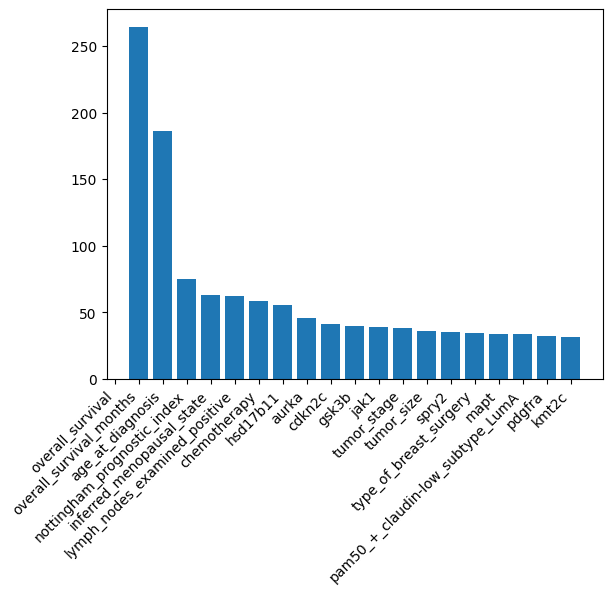

In [10]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


# Neural network with 1 hidden layer.

In [12]:
NN_model_1 = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model_1.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

2023-01-23 22:19:34.962944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-23 22:19:34.963056: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 22:19:34.963113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-01-23 22:19:34.972435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# fit the keras model on the dataset
model_1_fit = NN_model_1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 1s 13ms/step - loss: 0.2321 - mse: 0.7984 - val_loss: 0.1639 - val_mse: 0.5985
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1662 - mse: 0.5876 - val_loss: 0.1185 - val_mse: 0.4376
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1275 - mse: 0.4620 - val_loss: 0.0878 - val_mse: 0.3435
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1022 - mse: 0.3987 - val_loss: 0.0677 - val_mse: 0.2728
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0829 - mse: 0.3423 - val_loss: 0.0551 - val_mse: 0.2410
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0782 - mse: 0.3357 - val_loss: 0.0458 - val_mse: 0.1928
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0663 - mse: 0.2986 - val_loss: 0.0398 - val_mse: 0.1799
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0607 - mse: 0.2

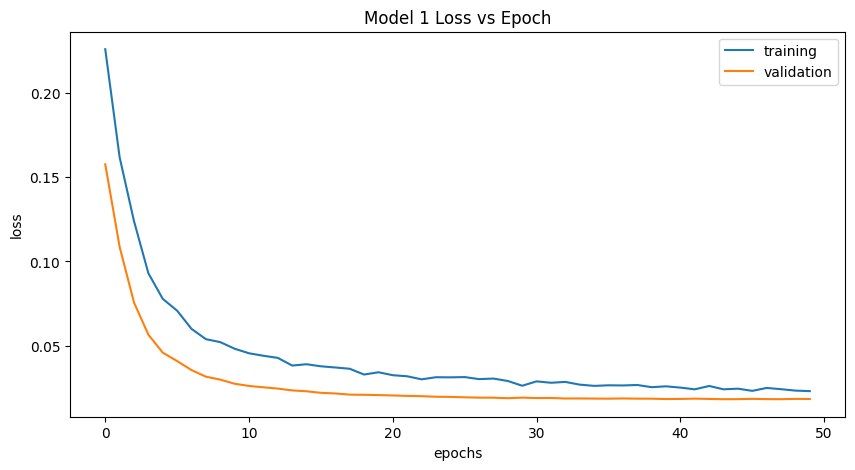

In [44]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_1_fit.history['loss'], label = 'training')
plt.plot(model_1_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 1 Loss vs Epoch')
plt.legend()

In [45]:
predictions_1=(NN_model_1.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 2ms/step


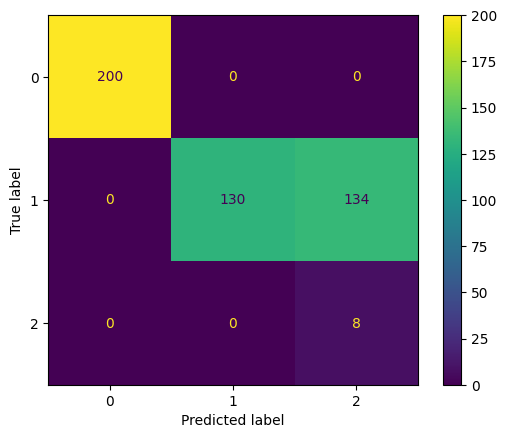

In [46]:
cm = confusion_matrix(predictions_1,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [59]:
#save the model
NN_model_1.save("NN_model_1")

# Fit the model using cross validation to get a more accurate score.

In [47]:
def my_model_1():
    return tf.keras.Sequential(
        [
            keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(1, activation='softplus') 
        
        ]
    )

In [57]:
    fold_no=1
    # Define per-fold score containers
    mse_per_fold = []
    loss_per_fold = []
    for kfold, (train, test) in enumerate(KFold(n_splits=3, 
                                    shuffle=True).split(X, y)):
        # clear the session 
        tf.keras.backend.clear_session()

        # calling the model and compile it 
        seq_model = my_model_1()
        seq_model.compile(optimizer = 'adam',
                    loss = 'mean_squared_logarithmic_error',
                    metrics=['mse'])

        #print('Train Set')
        #print(X.iloc[train].shape)
        #print(y.iloc[train].shape)

        #print('Test Set')
        #print(X.iloc[test].shape)
        #print(y.iloc[test].shape)

        # run the model 
        seq_model.fit(X.iloc[train], y.iloc[train],
                  batch_size=64, epochs=50, validation_data=(X.iloc[test], y.iloc[test]))
        #seq_model.save_weights(f'wg_{kfold}.h5')

        # Generate generalization metrics
        scores = seq_model.evaluate(X.iloc[test], y.iloc[test])
        print(f'Score for fold {fold_no}: {seq_model.metrics_names[0]} of {scores[0]}; {seq_model.metrics_names[1]} of {scores[1]*100}%')
        mse_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

    print(f"Average loss: {np.mean(loss_per_fold)}")
    print(f"Average mse: {np.mean(mse_per_fold)}")


Epoch 1/50
20/20 [==============================] - 1s 10ms/step - loss: 0.5122 - mse: 1.6931 - val_loss: 0.5454 - val_mse: 1.6667
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5001 - mse: 1.5137 - val_loss: 0.5454 - val_mse: 1.6667
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5019 - mse: 1.5152 - val_loss: 0.5454 - val_mse: 1.6666
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5003 - mse: 1.5156 - val_loss: 0.5454 - val_mse: 1.6666
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5007 - mse: 1.5408 - val_loss: 0.5454 - val_mse: 1.6666
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4998 - mse: 1.5445 - val_loss: 0.5445 - val_mse: 1.6648
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4806 - mse: 2.1919 - val_loss: 0.5214 - val_mse: 1.6107
Epoch 8/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4864 - mse: 1.6

20/20 [==============================] - 0s 5ms/step - loss: 0.4094 - mse: 2.2671 - val_loss: 0.3227 - val_mse: 1.0082
Epoch 24/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4057 - mse: 2.1654 - val_loss: 0.3437 - val_mse: 1.0739
Epoch 25/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3890 - mse: 2.0111 - val_loss: 0.3098 - val_mse: 0.9717
Epoch 26/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3763 - mse: 1.9815 - val_loss: 0.3219 - val_mse: 1.0017
Epoch 27/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3702 - mse: 1.8343 - val_loss: 0.2968 - val_mse: 0.9308
Epoch 28/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3604 - mse: 1.9763 - val_loss: 0.3009 - val_mse: 0.9612
Epoch 29/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3436 - mse: 1.4341 - val_loss: 0.2979 - val_mse: 0.9407
Epoch 30/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3253 - mse: 1.5354 -

## Neural network with 2 hidden layer.

In [60]:
NN_model_2 = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model_2.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [61]:
# fit the keras model on the dataset
model_2_fit = NN_model_2.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 1s 11ms/step - loss: 0.1383 - mse: 0.5025 - val_loss: 0.0408 - val_mse: 0.1715
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0430 - mse: 0.2441 - val_loss: 0.0220 - val_mse: 0.1292
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0303 - mse: 0.1782 - val_loss: 0.0233 - val_mse: 0.1285
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0290 - mse: 0.1727 - val_loss: 0.0206 - val_mse: 0.1172
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0252 - mse: 0.1509 - val_loss: 0.0190 - val_mse: 0.1151
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0243 - mse: 0.1502 - val_loss: 0.0190 - val_mse: 0.1166
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0222 - mse: 0.1379 - val_loss: 0.0231 - val_mse: 0.1333
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.1

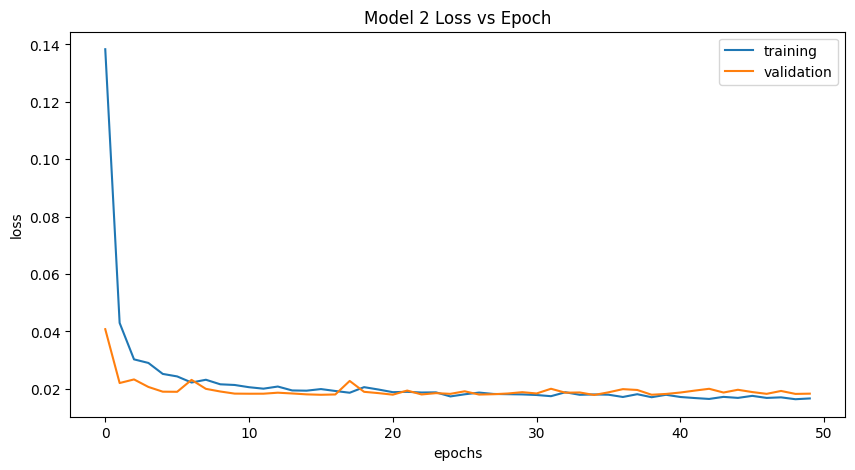

In [62]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_2_fit.history['loss'], label = 'training')
plt.plot(model_2_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 2 Loss vs Epoch')
plt.legend()

In [63]:
predictions_2=(NN_model_2.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 2ms/step


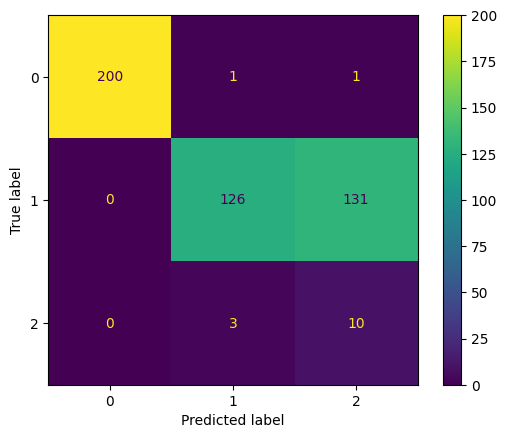

In [64]:
cm = confusion_matrix(predictions_2,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [65]:
#save the model
NN_model_2.save("NN_model_2")

In [66]:
def my_model_2():
    return tf.keras.Sequential(
        [
            keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(150, activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(1, activation='softplus') 
        
        ]
    )

In [67]:
fold_no=1
# Define per-fold score containers
mse_per_fold = []
loss_per_fold = []
for kfold, (train, test) in enumerate(KFold(n_splits=3, 
                                shuffle=True).split(X, y)):
    # clear the session 
    tf.keras.backend.clear_session()

    # calling the model and compile it 
    seq_model = my_model_2()
    seq_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])
    
    #print('Train Set')
    #print(X.iloc[train].shape)
    #print(y.iloc[train].shape)

    #print('Test Set')
    #print(X.iloc[test].shape)
    #print(y.iloc[test].shape)

    # run the model 
    seq_model.fit(X.iloc[train], y.iloc[train],
              batch_size=64, epochs=50, validation_data=(X.iloc[test], y.iloc[test]))
    #seq_model.save_weights(f'wg_{kfold}.h5')
    
    # Generate generalization metrics
    scores = seq_model.evaluate(X.iloc[test], y.iloc[test])
    print(f'Score for fold {fold_no}: {seq_model.metrics_names[0]} of {scores[0]}; {seq_model.metrics_names[1]} of {scores[1]*100}%')
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

print(f"Average loss: {np.mean(loss_per_fold)}")
print(f"Average mse: {np.mean(mse_per_fold)}")


Epoch 1/50
20/20 [==============================] - 1s 13ms/step - loss: 0.6405 - mse: 10.2782 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5221 - mse: 1.5715 - val_loss: 0.5056 - val_mse: 1.5460
Epoch 8/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5221 - mse: 1.

20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 24/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 25/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 26/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 27/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 28/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 29/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5129 - mse: 1.5592 - val_loss: 0.5240 - val_mse: 1.5707
Epoch 30/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5129 - mse: 1.5592 -

## Neural network with 3 hidden layers.

In [68]:
NN_model_3 = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(75, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model_3.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [69]:
# fit the keras model on the dataset
model_3_fit = NN_model_3.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 1s 12ms/step - loss: 0.1745 - mse: 0.6397 - val_loss: 0.0485 - val_mse: 0.2313
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0474 - mse: 0.2627 - val_loss: 0.0248 - val_mse: 0.1435
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0307 - mse: 0.1848 - val_loss: 0.0229 - val_mse: 0.1314
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0278 - mse: 0.1731 - val_loss: 0.0193 - val_mse: 0.1181
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0259 - mse: 0.1629 - val_loss: 0.0195 - val_mse: 0.1152
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0268 - mse: 0.1700 - val_loss: 0.0187 - val_mse: 0.1124
Epoch 7/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0260 - mse: 0.1656 - val_loss: 0.0196 - val_mse: 0.1154
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0226 - mse: 0.1

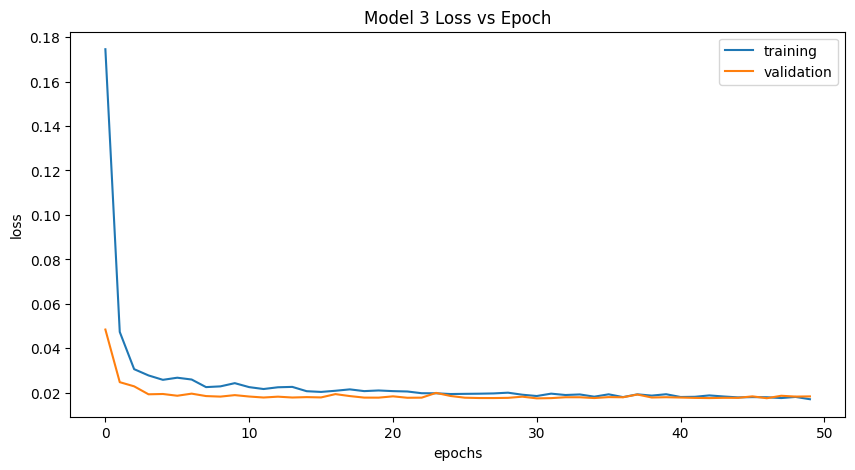

In [77]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_3_fit.history['loss'], label = 'training')
plt.plot(model_3_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 3 Loss vs Epoch')
plt.legend()

In [71]:
predictions_3=(NN_model_3.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 2ms/step


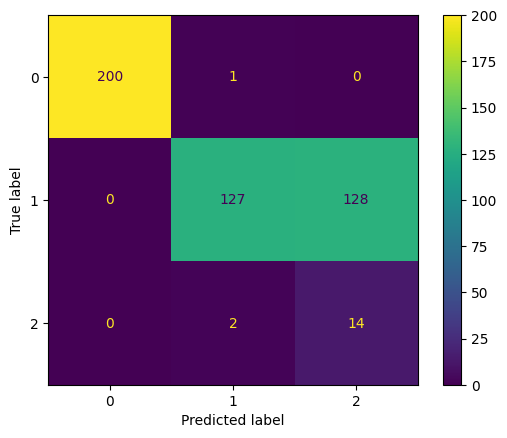

In [72]:
cm = confusion_matrix(predictions_3,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [73]:
#save the model
NN_model_3.save("NN_model_3")

In [74]:
def my_model_3():
    return tf.keras.Sequential(
        [
            keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(150, activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(75, activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(1, activation='softplus')  
        
        ]
    )

In [75]:
fold_no=1
# Define per-fold score containers
mse_per_fold = []
loss_per_fold = []
for kfold, (train, test) in enumerate(KFold(n_splits=3, 
                                shuffle=True).split(X, y)):
    # clear the session 
    tf.keras.backend.clear_session()

    # calling the model and compile it 
    seq_model = my_model_3()
    seq_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])
    
    #print('Train Set')
    #print(X.iloc[train].shape)
    #print(y.iloc[train].shape)

    #print('Test Set')
    #print(X.iloc[test].shape)
    #print(y.iloc[test].shape)

    # run the model 
    seq_model.fit(X.iloc[train], y.iloc[train],
              batch_size=64, epochs=50, validation_data=(X.iloc[test], y.iloc[test]))
    #seq_model.save_weights(f'wg_{kfold}.h5')
    
    # Generate generalization metrics
    scores = seq_model.evaluate(X.iloc[test], y.iloc[test])
    print(f'Score for fold {fold_no}: {seq_model.metrics_names[0]} of {scores[0]}; {seq_model.metrics_names[1]} of {scores[1]*100}%')
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

print(f"Average loss: {np.mean(loss_per_fold)}")
print(f"Average mse: {np.mean(mse_per_fold)}")


Epoch 1/50
20/20 [==============================] - 1s 15ms/step - loss: 0.5415 - mse: 3.5090 - val_loss: 0.4915 - val_mse: 1.4996
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5139 - mse: 2.0897 - val_loss: 0.4744 - val_mse: 1.4643
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5048 - mse: 2.0526 - val_loss: 0.4598 - val_mse: 1.4220
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4665 - mse: 2.0120 - val_loss: 0.3496 - val_mse: 1.1608
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4618 - mse: 2.3827 - val_loss: 0.2946 - val_mse: 0.9646
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3981 - mse: 1.8677 - val_loss: 0.2333 - val_mse: 0.7392
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.3359 - mse: 1.4057 - val_loss: 0.2415 - val_mse: 0.8357
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.2935 - mse: 1.0

20/20 [==============================] - 0s 9ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 24/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 25/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 26/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 27/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 28/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 29/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5136 - mse: 1.5512 - val_loss: 0.5225 - val_mse: 1.5866
Epoch 30/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5136 - mse: 1.5512 -